# Statistical Machine Learning on 
# Evolving Non-stationary Data Streams

# Outline

- Beyond i.i.d
- Stream Processing
- Incremental Learning
- Incremental Learning - Case Study
- Conclusion

![](./big-data.png)

# Beyond i.i.d

# Beyond i.i.d

* __Traditional machine learning and data mining__ assume the current observed data and the future data are **independent and identicically distributed (i.i.d)**.
* __Data samples__, in the **past and current time** do **not affect** the probability for **future** ones. 

# Beyond i.i.d

* Data samples arrive __continuously__, __online__ through unlimited **streams** often at __high speed__ [Sayed-Mouchaweh, 2016].
* The __process__ generating these data streams __may evolve over time__ (i.e. nonstationarity).

![](noniid.png)


# Beyond i.i.d

In order to deal with evolving data streams, the __model learnt from the streaming data__ must capture up-to-date __trends__ and __transient patterns__ in the stream. 

__Types of change in regression__
![](changes-types-labels.png)

# Beyond i.i.d

__Updating the model__ by incorporating new examples, we must also **eliminate the effects of outdated examples** representing outdated concepts through __one-pass__.

__Typical changes in classification__

[Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions)

![](changes-sample-labels.png)

# Beyond i.i.d

When __training and test data__ follow __different probability distributions__, but the __conditional distributions of output__ values given input points (i.e. __target function__) are __unchanged__, we face __covariate shift__ [Sugiyama et al., 2012]. 
![](covariate-shift.png)

# Stream Processing

# Stream Processing

Given a sequence of data (__a stream__), a series of operations (functions) is applied to each element in the stream, in a declarative way, we specify __what we want to achieve and not how__ [Bifet, 2010].
![](./stream-animation/streamanim.gif)


# Stream Processing

Data __Stream Processing__ is more challenging than __batch processing__ [Bifet, 2010]:
* The amount of data is __extremely large__, potentially infinite - __impossible to store__ 
* Only a __small summary__ can be computed and stored, and the rest is discarded - unfeasible to go over it
* The __speed of arrival is high__, so that each datum has to be processed in __real time__, and then discarded
* The __distribution generating the items__ can __change over time__
* __Data from the past__ may become __irrelevant (or even harmful)__ for the current summary

# Incremental Learning

# Incremental Learning

Unlike __conventional machine learning__, the __data flow__ targeted by __incremental learning__ becomes available __continuously__ over time and needs to be __processed in a single pass__.

The inherent __challenges__ here are: 

![](./streaming-challenges.png)



# Incremental Learning - Case Study

# Principal Component Analysis (PCA)

## PCA

![](basic-pca-problems.png)

Tackle the __inherent problems in traditional PCA__ impeding it to allow it to learn incrementally:
* Calculation of the __mean and other descriptive statistics__ as the data is available
* __Sorting the dominant eigenvalues__ in the rank update of the QR decomposition
* Calculating the __covariance matrix__

## Towards incremental PCA

Incremental __calculation of the mean and other descriptive statistics__ on the datastream.
![](streaming-mean.png)

## Towards incremental PCA

Incremental __updates depending on counts (i.e. histogram)__, which contain sorted eigenvalues.
![](streaming-histogram.png)

## Towards incremental PCA

Incremental __estimation of the covariance matrix__, as __neural synaptic weights__ converge to the eigenvectors (unique set of __optimal weights__ and __uncorrelated outputs__) [Axenie et al., 2019].
![](streaming-neural-covariance.png)

# Real-world application
![](coke.png)

#### Multi-class classification task (fault identification in predictive maintenance [Axenie et al., 2019])

Goal: identify faults in the production line by querying the eigenvalues and eigenvectors to extract the normal and faulty operation configuration prior to a multi-class classifier.

The datastream:

- 2M incoming events at 40 kHz.
- eigenvalues of the input $X$ are close to the class labels (i.e. $1, 2, ..., d$)
- eigenvectors are close to the canonical basis of $R^d$, where $d$ is the number of principal components to extract class number for the multi-class classification task (i.e. 10 classes, 9 faults and 1 normal).


## Performance analysis: Throughput
![](throughput-analysis.png)

## Performance analysis: Latency
![](latency-analysis.png)


## Performance analysis: Accuracy
![](performance-vals.png)
![](accuracy-analysis.png)

## Conclusions

## Conclusions

- Incremental learning on data streams is a challenging problem
- Data size, data speed and the underlying changes in the data properties yield new learning models
- Model accuracy, processing latency and processing throughput are usually a trade-off


# References

[Bifet, 2010] Albert Bifet - Adaptive Stream Mining Pattern Learning and Mining from Evolving Data Streams, IOS Press, 2010.

[Sugiyama et al., 2012] Masashi Sugiyama, Motoaki Kawanabe - Machine Learning in Non-Stationary Environments Introduction to Covariate Shift Adaptation-The MIT Press, 2012.

[Sayed-Mouchaweh, 2016] Moamar Sayed-Mouchaweh - Learning from Data Streams in Dynamic Environments-Springer International Publishing, 2016.

[Axenie et al., 2019] C. Axenie, Radu Tudoran, Stefano Bortoli, Mohamad Al Hajj Hassan, Alexander Wieder, Goetz Brasche, SPICE: Streaming PCA fault Identification and Classification Engine in Predictive Maintenance, IoT Stream Workshop, European Conf. on Machine Learning and Principles and Practice of Knowledge Discovery in Databases (ECML PKDD 2019).

![](moa.png)

# Volessung Notebook herunterladen

<img src="./qrcode.png" style="width = 200, height=200"/>

# Code sample for the Incremental PCA

In [1]:
import numpy as np

def update_incremental_mean(xbar, x, n):
        f = 1.0 / (n + 1.0)
        return (xbar.scale(1.0 - f)).plus(x.scale(f))

def IncrementalPCA(state,x):
        # recover state
        lambdaVal = state.get_lambda_val()
        Q = state.getQ()
        ind = state.getN()
        gamma = np.array(Q.num_cols())
    
        for id in range (1, Q.num_cols()):
            gamma.set(id, 1.0)
        
        gamma = gamma.scale(1.0 / (ind * ind))
        xbar = state.get_x_bar()

        # update the average
        state.setXbar(update_incremental_mean(xbar, x, ind))
        xbar = state.get_x_bar()

        # for the update remove the average
        x = x.minus(xbar).transpose()

        # update the predictor
        y = Q.mult(x)

        # prepare new state
        m = Q.numRows()
        n = Q.num_cols()
        gamy = gamma.element_multiply(y)
        b = Q.extract_vector(0).scale(y.get(0))
        A = np.array(m,n)
    
        A.setColumn(0, 0,
                (Q.extract_vector(0)
                        .minus(b.scale(gamy.get(0))))
                        .getDDRM()
                        .data)
        for i in range(1, n):
            b = b.plus(Q.extract_vector(i).scale(y.get(i)))
            A.setColumn(i, 0,
                    (Q.extract_vector(i)
                            .minus(b.scale(gamy.get(i))))
                            .getDDRM()
                            .data)

        A = A.plus(x.mult(gamy.transpose()))
        decay = ((gamma.minus(1.0)).scale(-1.0)).element_multiply(lambdaVal)
        increment = gamma.element_multiply(y).element_multiply(y)
        lambdaVal = increment.plus(decay)

        # wrap return values
        state.set_lambda_val(lambdaVal)
        state.set_q_val(A)
        return state

## Beyond i.i.d

The key idea of __covariate shift adaptation__ is to (softly) __choose informative training samples__ in a systematic way, by considering the __importance__ of each __training sample__ in the __prediction of test output values__, namely the ratio

$$ \frac{p_{te}(x_i^{tr})}{p_{tr}(x_i^{tr})}$$

Basically, __the expectation__ of a function $f$ (i.e. regression) over $x_{te}$ can be computed by the __importance-weighted expectation__ of the function over $x_{tr}$. 

Thus, the __difference of distributions__ can be systematically __adjusted__ by importance weighting.

## Towards incremental PCA

Converge from an initially __random set of synaptic weights__ to the __eigenvectors of the input autocorrelation__ in the eigenvalues order __minimizing the linear reconstruction (i.e. using Linear Least Squares)__. 
![](streaming-lls.png)

# Real-world application [Axenie et al., ECML PKDD 2019]
![](coke.png)

#### Multi-class classification task (fault identification in predictive maintenance [Axenie et al., 2019])

Goal: identify faults in the production line by querying the eigenvalues and eigenvectors to extract the normal and faulty operation configuration prior to a multi-class classifier.

The datastream:

- 2M incoming events at 40 kHz.
- eigenvalues of the input $X$ are close to the class labels (i.e. $1, 2, ..., d$)
- eigenvectors are close to the canonical basis of $R^d$, where $d$ is the number of principal components to extract class number for the multi-class classification task (i.e. 10 classes, 9 faults and 1 normal).


## Experimental setup
![](experimental-setup.png)

## Performance analysis
![](throughput-analysis.png)
![](latency-analysis.png)



## Accuracy
![](performance-vals.png)
![](accuracy-analysis.png)

## Incremental PCA - Example implementation on IRIS Dataset

In [3]:
%matplotlib notebook

from skmultiflow.data.file_stream import FileStream
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import numpy as np

<IPython.core.display.Javascript object>


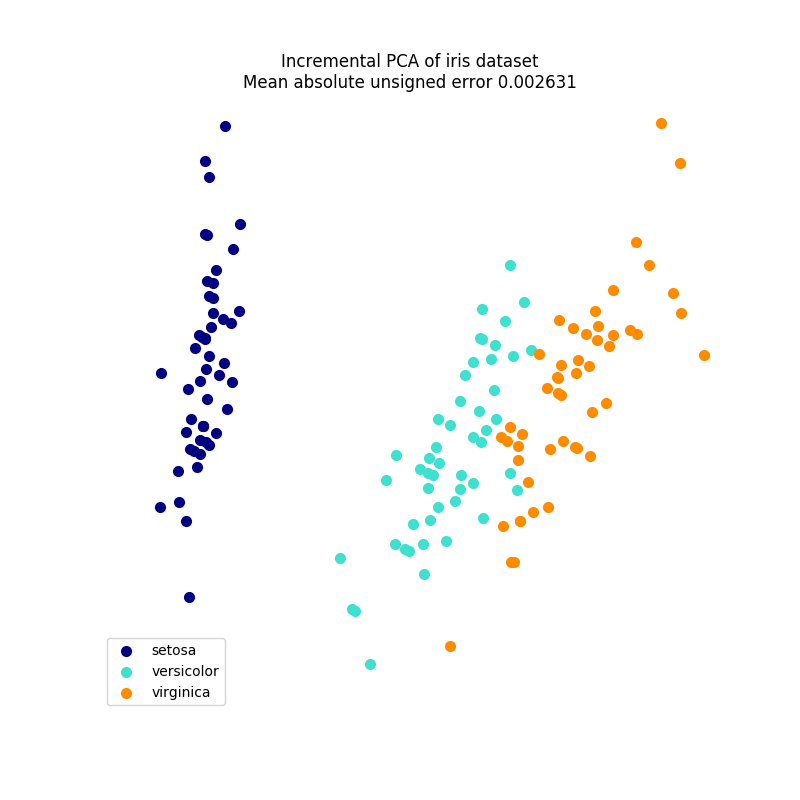

<IPython.core.display.Javascript object>


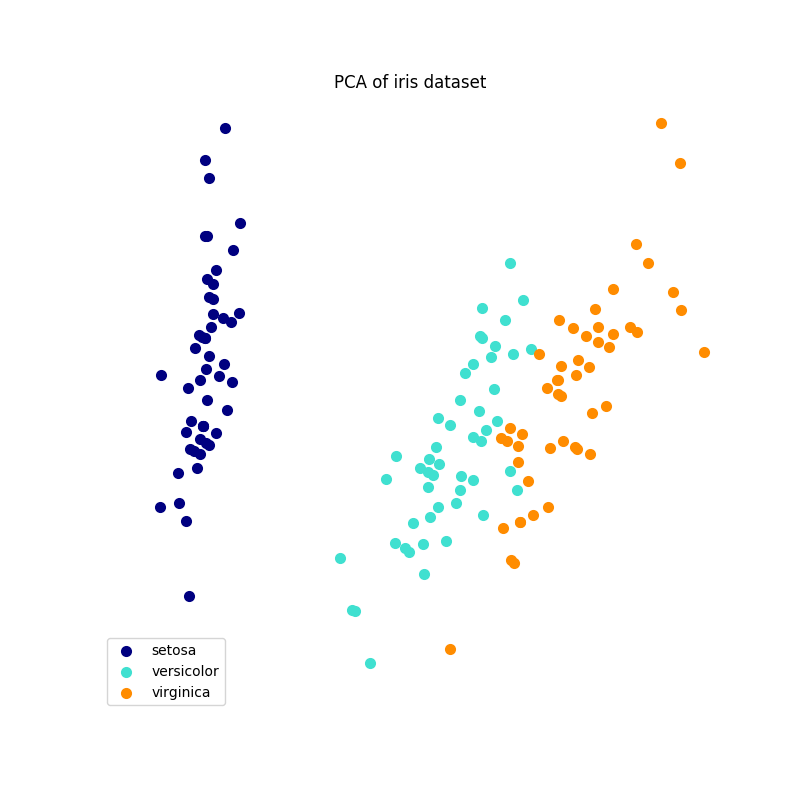

In [4]:
%matplotlib notebook

from skmultiflow.data.file_stream import FileStream
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import numpy as np

iris = load_iris()
stream = FileStream('./iris-dataset.csv')
stream.prepare_for_use()
stream.n_samples

X,y = stream.next_sample(stream.n_samples)

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=5)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ['navy', 'turquoise', 'darkorange']

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])
    plt.box('off')
    plt.axis('off')

plt.show()